Importing Dataset from Yahoo Finance

In [212]:
import pandas_datareader.data as web
from datetime import date
import datetime

start = datetime.datetime( 2006, 1, 2)
end = date.today()
stock = "HDFCBANK.NS"                          
data = web.DataReader( stock,"yahoo", start, end)
print(data)

                   High          Low  ...      Volume    Adj Close
Date                                  ...                         
2006-01-02    71.995003    70.699997  ...   2685520.0    43.341618
2006-01-03    71.800003    68.000000  ...   1282790.0    43.332512
2006-01-04    73.504997    71.400002  ...   5369920.0    44.471554
2006-01-05    74.300003    72.525002  ...   3853500.0    44.924141
2006-01-06    77.500000    73.000000  ...   8616860.0    46.713196
...                 ...          ...  ...         ...          ...
2020-09-21  1071.349976  1041.500000  ...   9921439.0  1049.300049
2020-09-22  1058.150024  1029.500000  ...   9310339.0  1035.400024
2020-09-23  1055.000000  1034.349976  ...   8039914.0  1047.250000
2020-09-24  1047.000000  1025.000000  ...   9904755.0  1030.400024
2020-09-25  1051.949951  1025.650024  ...  10159233.0  1044.000000

[3624 rows x 6 columns]


Plotting Training Data : HDFC Stock

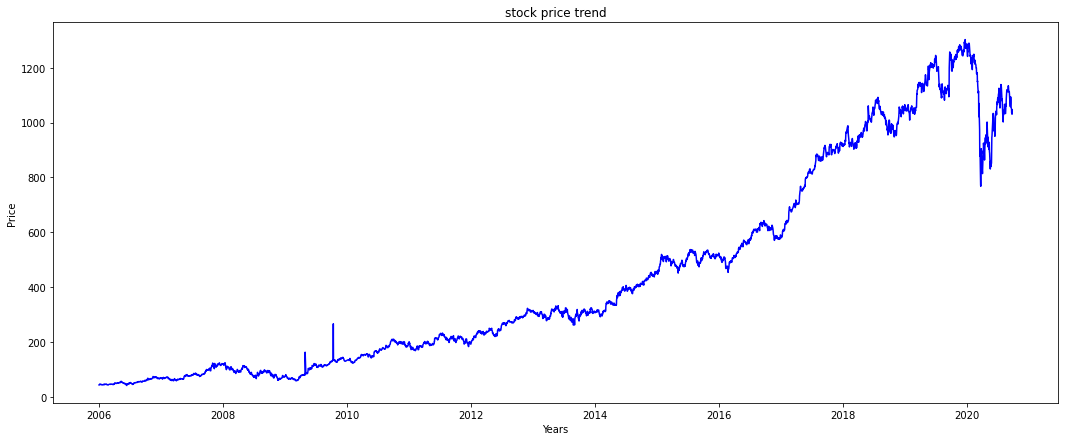

In [213]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,7))
plt.title("stock price trend")
plt.xlabel("Years")
plt.ylabel("Price")
plt.plot(data['Adj Close'], color= 'blue')
plt.show()

Dividing data into train/test sets; Scaling, Windowing and Reshaping Data

In [208]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = data['Adj Close'].values
df = df.reshape(-1, 1)

timestep = 50

dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-timestep:])

scaler1 = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler1.fit_transform(dataset_train)
dataset_test = scaler1.fit_transform(dataset_test)

def create_dataset(dataset, timestep):
    x = []
    y = []
    for i in range(timestep, dataset.shape[0]):
        x.append(dataset[i-timestep:i, 0])
        y.append(dataset[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y 

x_train, y_train = create_dataset( dataset_train, timestep)
x_test, y_test = create_dataset( dataset_test, timestep)


# Reshape features for LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Building Model: 
1. LSTM : 
    Required Hyperparameter Tuning

In [214]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os

model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dense(units=1))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 50, 96)            37632     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_15 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 96)                74112     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 97        
Total params: 185,953
Trainable params: 185,953
Non-trainable params: 0
________________________________________________

In [215]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics='mse')
model.fit(x_train, y_train, epochs = 50, batch_size=32)
model.save('LSTMmodel.h5')

Epoch 1/50
90/90 [==============================] - 10s 112ms/step - loss: 0.0042 - mse: 0.0042
Epoch 2/50
90/90 [==============================] - 11s 119ms/step - loss: 3.8733e-04 - mse: 3.8733e-04
Epoch 3/50
90/90 [==============================] - 11s 118ms/step - loss: 4.7313e-04 - mse: 4.7313e-04
Epoch 4/50
90/90 [==============================] - 11s 119ms/step - loss: 3.4783e-04 - mse: 3.4783e-04
Epoch 5/50
90/90 [==============================] - 11s 118ms/step - loss: 3.4240e-04 - mse: 3.4240e-04
Epoch 6/50
90/90 [==============================] - 11s 121ms/step - loss: 4.3507e-04 - mse: 4.3507e-04
Epoch 7/50
90/90 [==============================] - 11s 121ms/step - loss: 5.2128e-04 - mse: 5.2128e-04
Epoch 8/50
90/90 [==============================] - 11s 118ms/step - loss: 2.6527e-04 - mse: 2.6527e-04
Epoch 9/50
90/90 [==============================] - 11s 119ms/step - loss: 2.9039e-04 - mse: 2.9039e-04
Epoch 10/50
90/90 [==============================] - 11s 120ms/step - lo

Run on Test Data

In [216]:
model = load_model('LSTMmodel.h5')
predictions = model.predict(x_test)
predictions = scaler1.inverse_transform(predictions)

In [217]:
test_loss = model.evaluate(x_test, y_test)

23/23 [==============================] - 1s 31ms/step - loss: 0.0028 - mean_squared_error: 0.0028


Visualizing Results

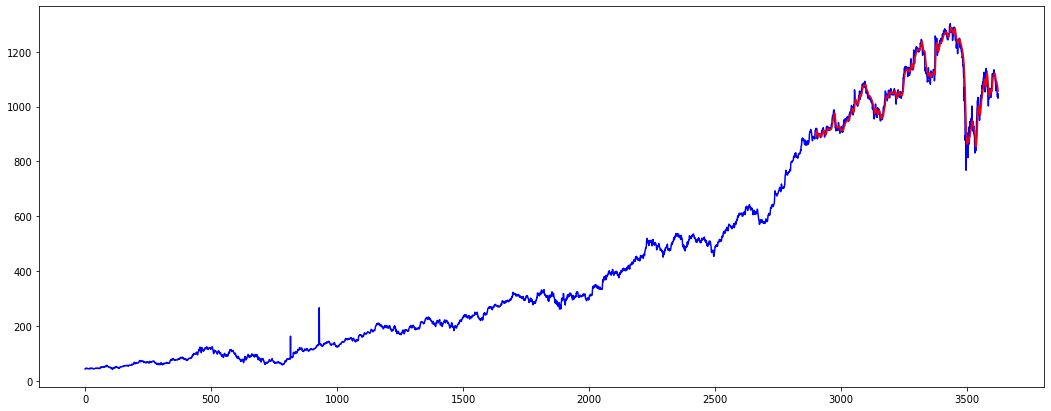

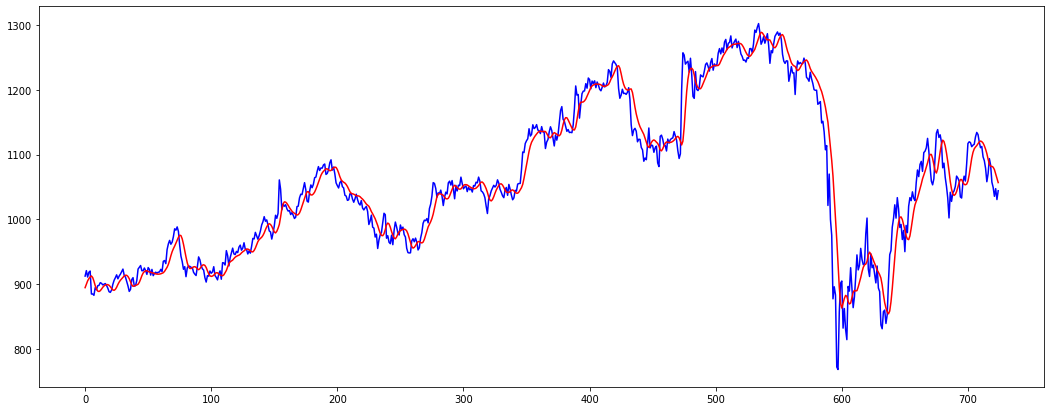

In [218]:
fig, ax = plt.subplots(figsize=(18,7))
plt.plot(df, color='blue')
ax. plot(range(len(y_train)+timestep, len(y_train)+timestep+len(predictions)), predictions, color='red')

y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))
fig, ax = plt.subplots(figsize=(18,7))
ax.plot( y_test_scaled, color='blue')
plt.plot(predictions, color='red')

Predicting in Future

In [219]:
import pandas_datareader.data as web
from datetime import date
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

SELECT STOCK TO BE PREDICTED 


1.   Nifty 50 (^NSEI)
2.   S&P BSE SENSEX (^BSESN)
3.   Hindustan Unilever Limited (HINDUNILVR.NS)
4.   Reliance Industries Limited (RELIANCE.NS)
5.   Infosys Limited (INFY.NS)
6.   Tata Consultancy Services Limited (TCS.NS)
7.   HDFC Bank Limited (HDFCBANK.NS)



In [220]:
def select_stock(s):
  if s == 1 : 
    stock = "^NSEI"
  elif s == 2 : 
    stock = "^BSESN"
  elif s == 3 : 
    stock = "HINDUNILVR.NS"
  elif s == 4 : 
    stock = "RELIANCE.NS"
  elif s == 5 : 
    stock = "INFY.NS"
  elif s == 6 : 
    stock = "TCS.NS"
  elif s == 7 : 
    stock = "HDFCBANK.NS"  
  return stock

Getting Data of selected stock

In [221]:
def get_data(stock, scaler1):
  start = date.today() - datetime.timedelta(days=84)
  end = date.today()
  data = web.DataReader( stock,"yahoo", start, end)
  df1 = data.reset_index()['Adj Close']
  df1 = scaler1.fit_transform(np.array(df1).reshape(-1,1))
  test_data = df1[-50:,:]
  a_input=test_data[len(test_data) - 50:].reshape(1,-1)
  t_input=list(x_input)
  t_input=a_input[0].tolist()
  return a_input, t_input

Prediting Stock Price for next 10 days

In [223]:
def predict(a_input, t_input):
  output=[]
  steps=50
  i=0
  while(i<10):
    if(len(t_input)>50):
        a_input=np.array(t_input[1:])
        a_input=a_input.reshape(1,-1)
        a_input = a_input.reshape((1, steps, 1))
        yhat = model.predict(a_input, verbose=0)
        t_input.extend(yhat[0].tolist())
        t_input=t_input[1:]
        output.extend(yhat.tolist())
        i=i+1
    else:
        a_input = a_input.reshape((1, steps,1))
        yhat = model.predict(a_input, verbose=0)
        t_input.extend(yhat[0].tolist())
        output.extend(yhat.tolist())
        i=i+1
  return output    

Plotting the Graph

In [224]:
import matplotlib.pyplot as plt

def plot(output, scaler1):
  new_day=np.arange(1,51)
  pred_day=np.arange(51,61)
  plt.figure(figsize=(18,7))
  plt.plot(new_day,scaler1.inverse_transform(df1[len(df1)- 50:]))
  plt.plot(pred_day,scaler1.inverse_transform(output))

Loading model for prediction

In [225]:
from keras.models import load_model
model = load_model('LSTMmodel.h5')

NIFITY 50

[[11168.08308542]
 [11115.55507399]
 [11097.75538371]
 [11101.46671008]
 [11114.83446662]
 [11130.45432271]
 [11144.72181541]
 [11156.32996805]
 [11165.11403672]
 [11171.37641363]]


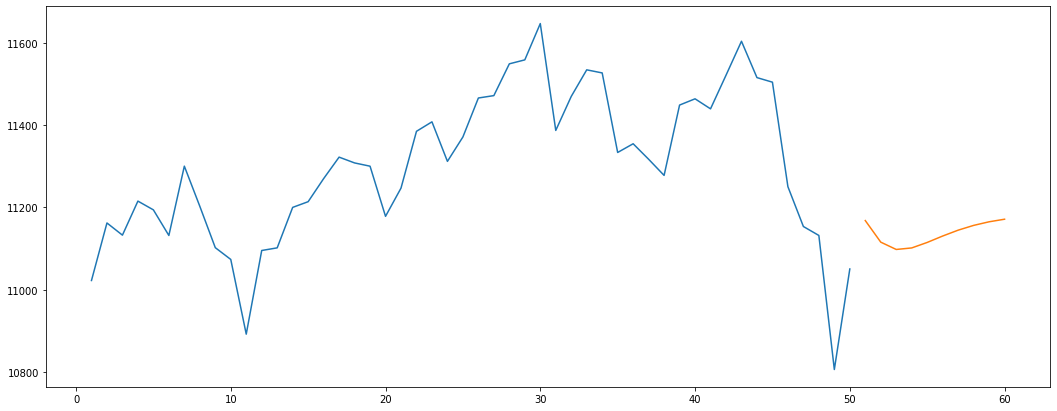

In [226]:
nifty = select_stock(1)
a_input, t_input = get_data(nifty, scaler1)
output = predict(a_input, t_input)
plot(output, scaler1)
print(scaler1.inverse_transform(output))

S&P BSE SENSEX (^BSESN)

[[37778.54905035]
 [37602.61134767]
 [37544.04568614]
 [37557.83306068]
 [37603.79573403]
 [37656.94698457]
 [37705.2029495 ]
 [37744.24395108]
 [37773.58742349]
 [37794.30663665]]


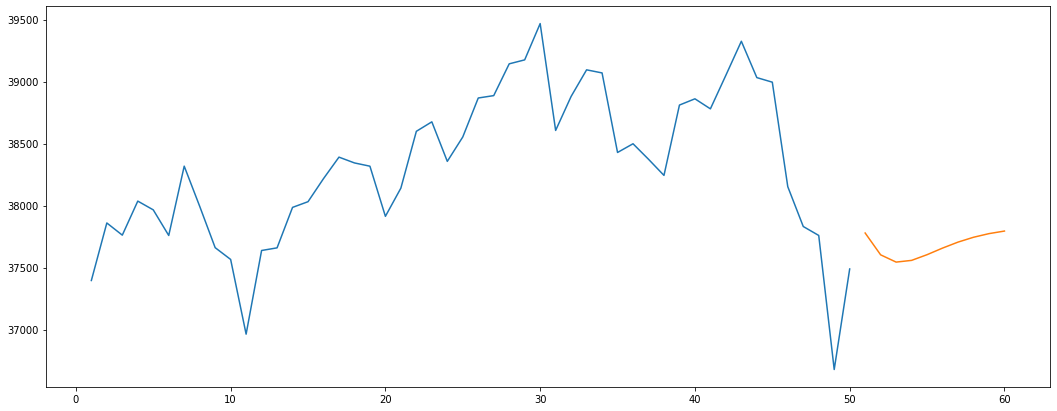

In [227]:
sensex = select_stock(2)
a_input, t_input = get_data(sensex, scaler1)
output = predict(a_input, t_input)
plot(output, scaler1)
print(scaler1.inverse_transform(output))

Hindustan Unilever Limited (HINDUNILVR.NS)


[[2063.80962952]
 [2063.3612468 ]
 [2065.13346333]
 [2067.51733958]
 [2069.72358281]
 [2071.46009344]
 [2072.67955653]
 [2073.4344259 ]
 [2073.80824162]
 [2073.88717534]]


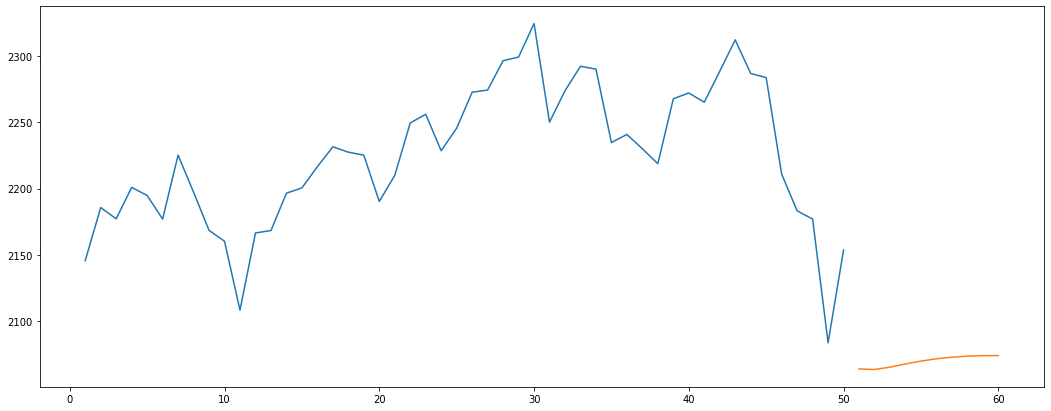

In [228]:
hindu = select_stock(3)
a_input, t_input = get_data(hindu, scaler1)
output = predict(a_input, t_input)
plot(output, scaler1)
print(scaler1.inverse_transform(output))

Reliance Industries Limited (RELIANCE.NS)

[[2217.84219427]
 [2209.13499419]
 [2206.30786985]
 [2207.0511799 ]
 [2209.49545382]
 [2212.47310821]
 [2215.37181908]
 [2217.92481626]
 [2220.0541798 ]
 [2221.77321624]]


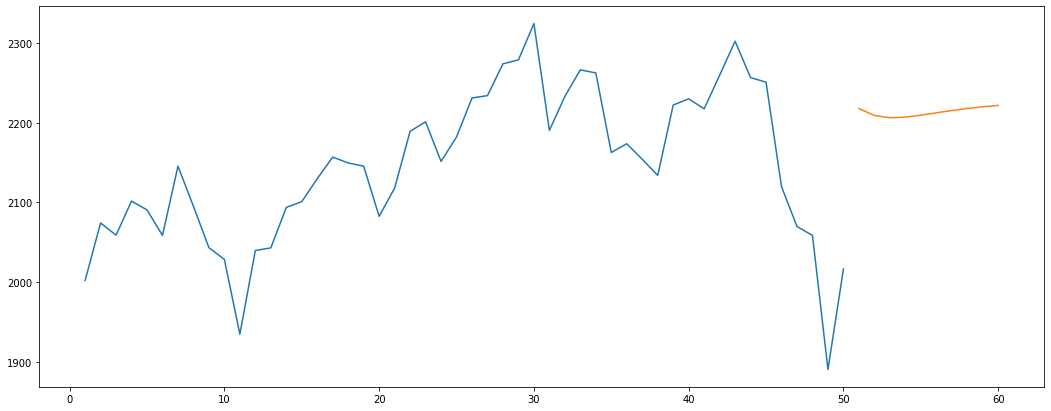

In [229]:
reliance = select_stock(4)
a_input, t_input = get_data(reliance, scaler1)
output = predict(a_input, t_input)
plot(output, scaler1)
print(scaler1.inverse_transform(output))

Infosys Limited (INFY.NS)

[[998.04920534]
 [996.43243275]
 [995.00320909]
 [993.87970812]
 [993.09733752]
 [992.63247173]
 [992.43148596]
 [992.43231331]
 [992.57579797]
 [992.81154794]]


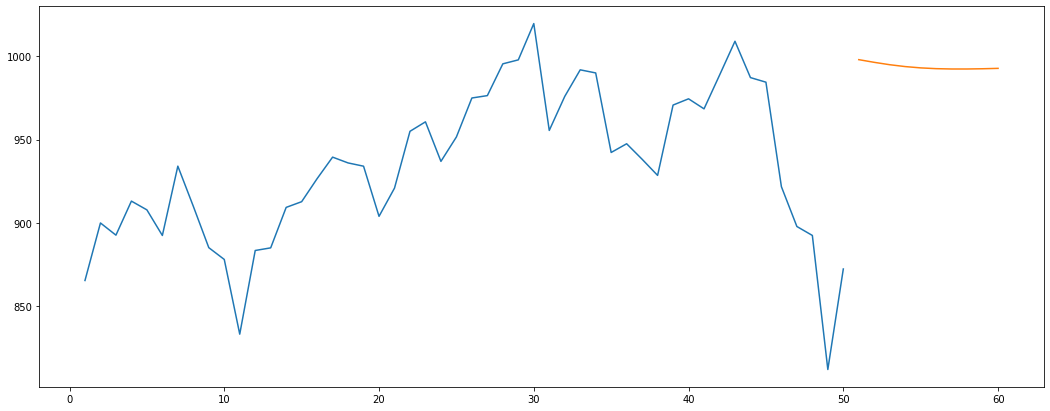

In [230]:
infy = select_stock(5)
a_input, t_input = get_data(infy, scaler1)
output = predict(a_input, t_input)
plot(output, scaler1)
print(scaler1.inverse_transform(output))

Tata Consultancy Services Limited (TCS.NS)


[[2432.67517668]
 [2421.30812624]
 [2415.07577098]
 [2412.61482744]
 [2412.40195398]
 [2413.31761489]
 [2414.68399231]
 [2416.13907063]
 [2417.50978396]
 [2418.72414315]]


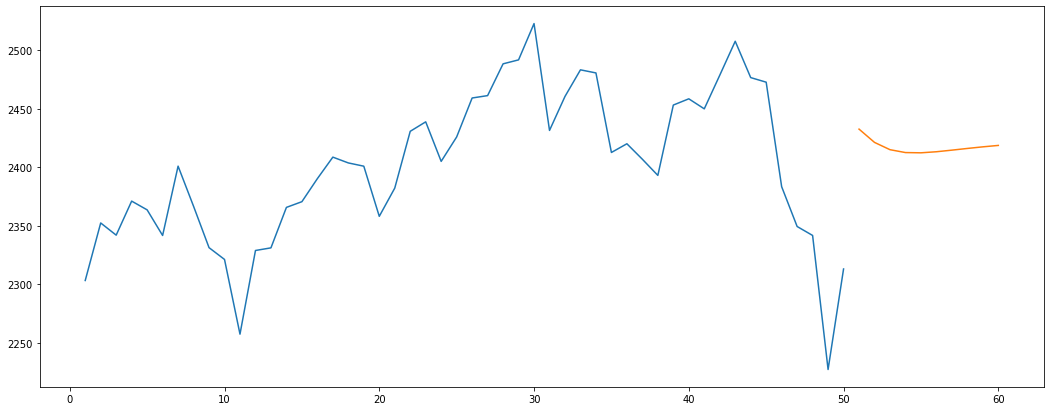

In [231]:
tcs = select_stock(6)
a_input, t_input = get_data(tcs, scaler1)
output = predict(a_input, t_input)
plot(output, scaler1)
print(scaler1.inverse_transform(output))

HDFC Bank Limited (HDFCBANK.NS)

[[1050.95548823]
 [1048.62862461]
 [1048.43417942]
 [1049.35136934]
 [1050.62456393]
 [1051.83892564]
 [1052.82321768]
 [1053.54006161]
 [1054.01381345]
 [1054.28959591]]


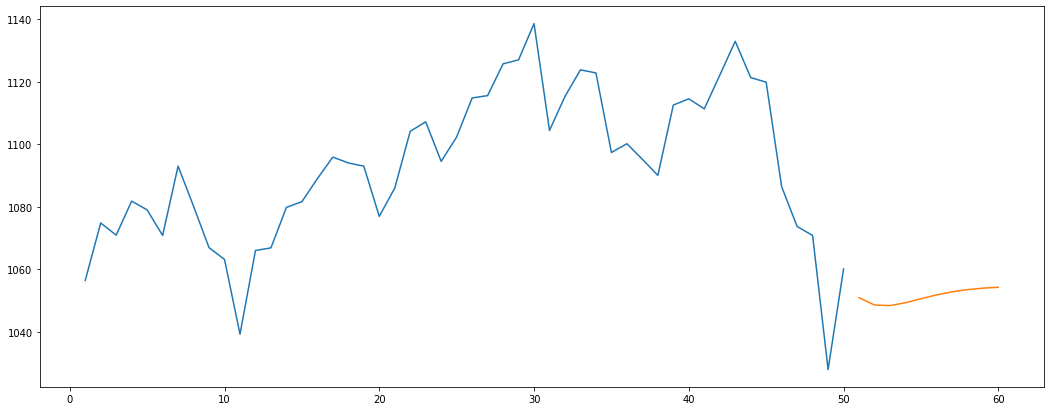

In [232]:
hdfc = select_stock(7)
a_input, t_input = get_data(hdfc, scaler1)
output = predict(a_input, t_input)
plot(output, scaler1)
print(scaler1.inverse_transform(output))

Saving scaler1 using pickle 

In [234]:
import pickle
scalerfile = 'scaler1.sav'
pickle.dump(scaler1, open(scalerfile, 'wb'))